In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "Serif"
})

# A Neural Network from Scratch using JAX

JAX is a collection of tools that wrap the Accelerated Linear Algebra library [XLA](https://github.com/openxla/xla/tree/main), to make highly performant linear algebra operations in devices such as GPUs and TPUs accessible in Python. It is built by Google, and should be considered more as an alternative on the abstraction level of NumPy as opposed to higher-level libraries like PyTorch or Tensorflow.

JAX's most important features are encapsulated in it's name:
- J: Just-in-Time (JIT) compilation.
- A: Autograd.
- X: XLA.

In this notebook the use of JAX is explored in the context of a MLP classifier trained on the MNIST dataset.

First we'll initialize the NN with normally distributed random numbers.

In [3]:
import numpy as np
import jax
from jax.typing import ArrayLike

seed = 0
mnist_img_size = 784
mnist_num_classes = 10

def init_MLP(
	layer_widths: list[int],
  parent_key: ArrayLike,
  scale: float = 0.01
) -> list[jax.Array]:
  
  params = []
  keys = jax.random.split(parent_key, num=len(layer_widths)-1)
  
  for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
    weight_key, bias_key = jax.random.split(key)
    params.append([
      scale*jax.random.normal(weight_key, shape=(out_width, in_width)), # weights
      scale*jax.random.normal(bias_key, shape=(out_width,)),            # biases
    ])
  return params

# The first param is 784 since that is the number of pixels in an MNIST image
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([mnist_img_size, 512, 256, mnist_num_classes], key)

print(jax.tree.map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [5]:
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax import jit


def MLP_predict(params: list, activation: jnp.ndarray) -> jnp.ndarray:
  
  # Loop over the NN layers, only performing ReLU on the hidden layers
  for index, (w, b) in enumerate(params):
    if index < len(params) - 1:
      activation = jax.nn.relu(jnp.dot(w, activation) + b)
    else:
      logits = jnp.dot(w, activation) + b
   
	# Using the log-sum-exp trick, which avoids avoid numerical instability when taking logarithms of small numbers
	# log( exp(o_1) / sum_i(o_i) ) = log(exp(o_1)) - log(exp(o_1) + exp(o_2) + ...) 
  return logits - logsumexp(logits)

# Below we test the implementation of MLP_predict using a dummy image
# We expect a shape of (10,) since there are 10 classes in the MNIST dataset
dummy_image_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_image_flat.shape)

prediction = MLP_predict(MLP_params, dummy_image_flat)
print(prediction.shape)

(784,)
(10,)


Next, we create a batched version of MLP_predict (using `jax`'s `vmap`) and test it on a list of test images. Use of `vmap` ensures that the batch prediction operation is vectorized.

In [6]:
batched_MLP_predict = jax.vmap(MLP_predict, in_axes=(None, 0))

# Test on a batch of test images
dummy_images_batch_flat = np.random.randn(16, mnist_img_size)
print(dummy_images_batch_flat.shape)
predictions = batched_MLP_predict(MLP_params, jnp.array(dummy_images_batch_flat))
print(predictions.shape)

(16, 784)
(16, 10)


# Dataloading

Dataloading is done using PyTorch. Jax does not reimplement any of PyTorch or Tensorflows dataloading functionality since the authors believe that it is already implemented well in PyTorch and Tensorflow.

We use a custom transform function to convert from a PIL image type to NumPy array.

In [7]:
from torchvision.datasets import MNIST
from PIL import Image


def transform_to_numpy(x: Image.Image) -> np.ndarray:
  """
  	Custom transform function to transform images from PIL.Image.Image type to np.ndarray.
    np.ravel is used to convert from a 2D 28x28 array to a 1D array of length 784.
  """
  return np.ravel(np.array(x, dtype=np.float32))


training_data = MNIST(root='../data/train_mnist', train=True, download=True, transform=transform_to_numpy)
test_data = MNIST(root='../data/test_mnist', train=False, download=True, transform=transform_to_numpy)
print(type(training_data), "\n")

print("Verify that the returned type is a numpy.ndarray:", type(training_data[0][0]), training_data[0][0].shape)

<class 'torchvision.datasets.mnist.MNIST'> 

Verify that the returned type is a numpy.ndarray: <class 'numpy.ndarray'> (784,)


In [8]:
from torch.utils.data import DataLoader
import numpy as np


def collate_fn(batch: list[tuple[np.ndarray, int]]) -> tuple[np.ndarray, np.ndarray]:
    """
    Custom collate function for DataLoader that transposes the data into 
    one ndarray of all images, and one ndarray of all labels
    
    Args:
        batch (list[tuple[np.ndarray, int]]): A list of tuples where each tuple contains an input array and a label.
    
    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing a stacked array of inputs and an array of labels.
    """
    transposed_data = list(zip(*batch))
    return np.stack(transposed_data[0]), np.array(transposed_data[1])


batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [9]:
train_images = jnp.array(training_data.data).reshape(len(training_data), -1)
train_labels = jnp.array(training_data.targets)

test_images = jnp.array(test_data.data).reshape(len(test_data), -1)
test_labels = jnp.array(test_data.targets)

# Training Loop

Since this is a classification problem, we use the cross-entropy loss.

In [10]:
def loss_function(params, images, targets) -> jax.Array:
  """
	Update function for the MLP model.

	Args:
			params: Model parameters (weights and biases).
			images: Input data (batch of images).
			targets: True labels for the input data (one-hot encoded).

	Returns:
			A scalar value representing the negative mean of the element-wise product
			of predictions and true labels.
	"""
  predictions = batched_MLP_predict(params, images) # shape: (batch_dimension, number_of_classification_classes)
  
  # Calculate the simplified cross-entropy loss
  return -jnp.mean(predictions * targets)

In [11]:
from jax.typing import ArrayLike

@jit
def update(
  params, images: np.ndarray, 
  one_hot_groundtruth_labels: ArrayLike, 
  learning_rate: float = 0.01
):
  loss, grads = jax.value_and_grad(loss_function)(params, images, one_hot_groundtruth_labels)
  return loss, jax.tree.map(lambda p, gradient: p - learning_rate * gradient, params, grads)

In [12]:
def accuracy(params, dataset, dataset_labels):
  dataset_predictions = jnp.argmax(batched_MLP_predict(params, dataset), axis=1)
  return jnp.mean(dataset_labels == dataset_predictions)

In [13]:
num_epochs = 10

# Initialize the NN
MLP_params = init_MLP([mnist_img_size, 512, 256, mnist_num_classes], key)

for epoch in range(num_epochs):

  for batch_id, (images, groundtruth_labels) in enumerate(train_dataloader):
    one_hot_groundtruth_labels = jax.nn.one_hot(groundtruth_labels, num_classes=len(MNIST.classes))
  	
    loss, MLP_params = update(MLP_params, images, one_hot_groundtruth_labels)
    
    if batch_id % 50 == 0:
      print(one_hot_groundtruth_labels.shape, loss)
      
  train_accuracy = accuracy(MLP_params, train_images, train_labels)
  test_accuracy = accuracy(MLP_params, test_images, test_labels)
  print(f"Epoch {epoch}, train accuracy = {train_accuracy} test accuracy = {test_accuracy}")

(128, 10) 0.22890113
(128, 10) 0.0915662
(128, 10) 0.052715488


(128, 10) 0.047740005
(128, 10) 0.040073633
(128, 10) 0.042304702
(128, 10) 0.026357839
(128, 10) 0.042539444
(128, 10) 0.04062575
(128, 10) 0.024704715
Epoch 0, train accuracy = 0.9147000312805176 test accuracy = 0.9190999865531921
(128, 10) 0.020232102
(128, 10) 0.03668762
(128, 10) 0.017615011
(128, 10) 0.03806792
(128, 10) 0.0358774
(128, 10) 0.02519854
(128, 10) 0.02176924
(128, 10) 0.040552225
(128, 10) 0.02468437
(128, 10) 0.037258524
Epoch 1, train accuracy = 0.9339166879653931 test accuracy = 0.9352999925613403
(128, 10) 0.025394147
(128, 10) 0.030537827
(128, 10) 0.022285556
(128, 10) 0.028343344
(128, 10) 0.021291852
(128, 10) 0.021513391
(128, 10) 0.016354632
(128, 10) 0.018209204
(128, 10) 0.009129996
(128, 10) 0.013650469
Epoch 2, train accuracy = 0.9462167024612427 test accuracy = 0.942799985408783
(128, 10) 0.018803295
(128, 10) 0.012468285
(128, 10) 0.016710464
(128, 10) 0.022825977
(128, 10) 0.023683501
(128, 10) 0.024804804
(128, 10) 0.027280925
(128, 10) 0.030304605

Based on the above, by the end of epoch 9 the MLP was able to achieve 98.7% accuracy on the training set and 97.4% accuracy on the test set.

 # Visualizations

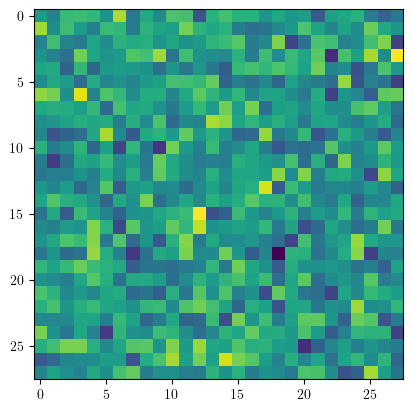

In [14]:
import matplotlib.pyplot as plt

w = MLP_params[0][0]
w.shape

w_single = w[0,:].reshape(28, 28)
plt.imshow(w_single); plt.show()

Next we will use t-SNE to visualise embeddings which allows us to get a sense of how well the neural network has learned useful features that detect similarity between the images.

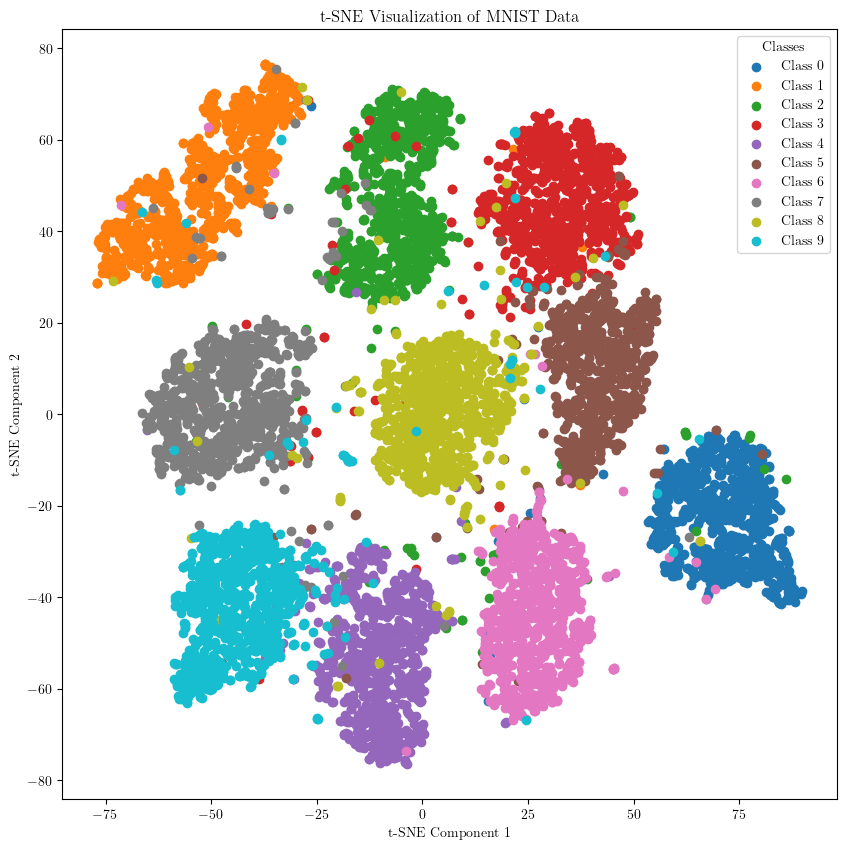

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Use a modified version of the predict_MLP function that returns the hidden layer activations
@jit
def MLP_predict_t_SNE(params: list, activation: jnp.ndarray) -> jnp.ndarray:
    # Loop over the NN layers, only performing ReLU on the hidden layers
    for index, (w, b) in enumerate(params):
        if index < len(params) - 1:
            activation = jax.nn.relu(jnp.dot(w, activation) + b)
        else:
            break
    return activation

MLP_predict_modified_batched = jax.vmap(MLP_predict_t_SNE, in_axes=(None, 0))
batch_activations = MLP_predict_modified_batched(MLP_params, test_images)
batch_activations.shape  # (batch_size, final_hidden_layer_size)

t_sne_embeddings = TSNE(n_components=2, perplexity=30).fit_transform(batch_activations)

# Plotting the t-SNE embeddings with a legend
plt.figure(figsize=(10, 10))
for class_id in range(len(MNIST.classes)):
    plt.scatter(t_sne_embeddings[labels == class_id, 0], t_sne_embeddings[labels == class_id, 1], label=f"Class {class_id}")

plt.legend(title="Classes")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of MNIST Data")
plt.show()

It can also be interesting to plot the MNIST samples themselves instead of circles.

The `@jit` decorator tells JAX to just-in-time compile the function, allowing it to be optimized fully using the XLA algorithms.

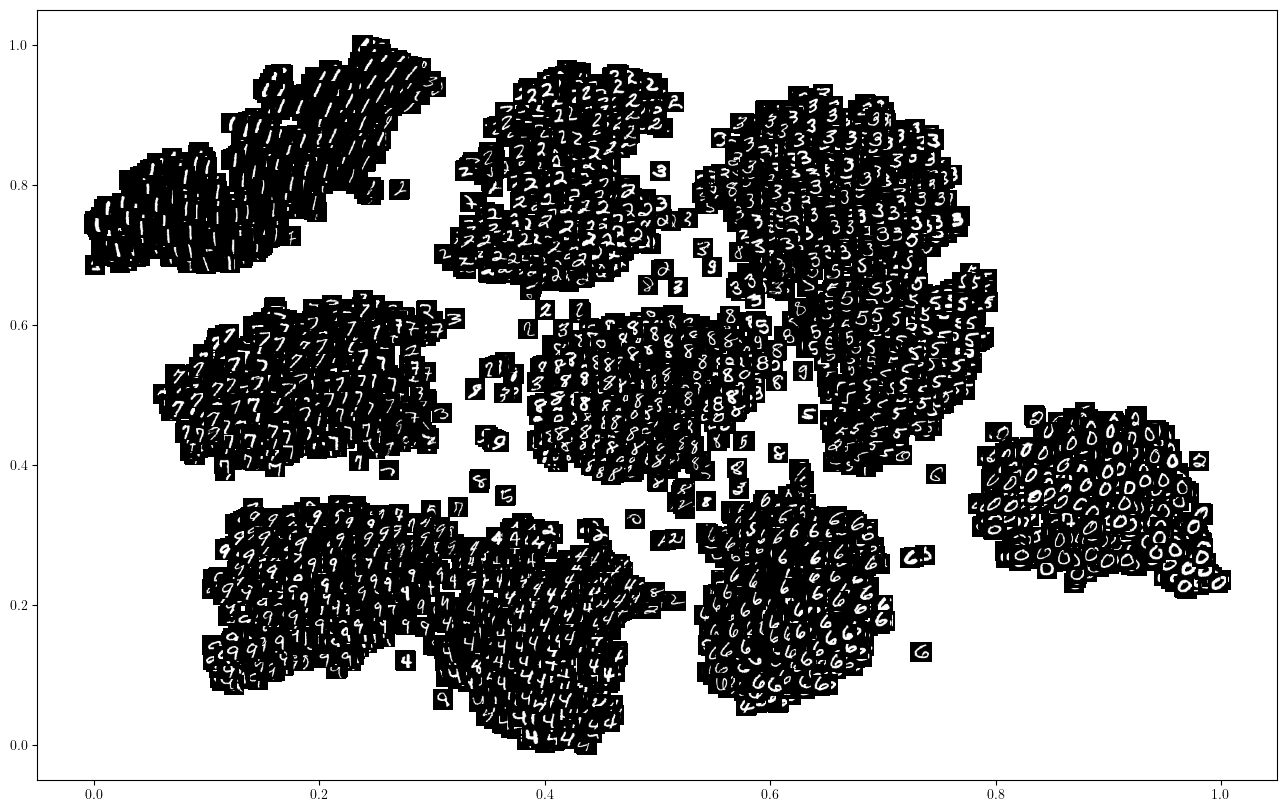

In [17]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from sklearn.manifold import TSNE
import jax
import jax.numpy as jnp

# Use a modified version of the predict_MLP function that returns the hidden layer activations

@jit
def MLP_predict_t_SNE(params: list, activation: jnp.ndarray) -> jnp.ndarray:
	# Loop over the NN layers, only performing ReLU on the hidden layers
	for index, (w, b) in enumerate(params):
		if index < len(params) - 1:
			activation = jax.nn.relu(jnp.dot(w, activation) + b)
		else:
			break
	return activation


MLP_predict_modified_batched = jax.vmap(MLP_predict_t_SNE, in_axes=(None, 0))
batch_activations = MLP_predict_modified_batched(MLP_params, test_images)
batch_activations.shape  # (batch_size, final_hidden_layer_size)

t_sne_embeddings = TSNE(n_components=2, perplexity=30).fit_transform(batch_activations)

# Normalize the t-SNE embeddings
t_sne_min, t_sne_max = np.min(t_sne_embeddings, axis=0), np.max(t_sne_embeddings, axis=0)
t_sne_embeddings = (t_sne_embeddings - t_sne_min) / (t_sne_max - t_sne_min)

fig, ax = plt.subplots(figsize=(16, 10))
zoom = 0.5

for i in range(len(test_images)):
	x, y = t_sne_embeddings[i, 0], t_sne_embeddings[i, 1]
	img = test_images[i].reshape(28, 28)  # Assuming MNIST images are 28x28
	im = OffsetImage(img, zoom=zoom, cmap='gray')
	ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
	ax.add_artist(ab)
	# ax.text(x, y, str(labels[i]), color='red', fontsize=8, ha='center', va='center')
	ax.update_datalim([(x, y)])

ax.autoscale()
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of MNIST Data")
plt.show()